# The Anatomy of a Playlist: A Spotify API Tutorial
**Team**: Daisy Abbott, Hannah Guo, Amy Zhong

**Introduction:** The *Anatomy of a Playlist* tutorial aims to equip users (you!) with the skills to generate creative data visualizations, culminating in a personalized playlist cover "artwork" based on the mood of their own playlist. Through this tutorial, users will learn to fetch, analyze, and visualize their playlist data using the Spotify Web API. This API allows us to access extensive information on playlists and tracks; it contains especially rich metadata on individual tracks, such as their mood (valence) and tempo. Our tutorial will demonstrate how to generate artistic visualizations based on these scores. In addition to gaining familiarity working with APIs, users will work with the pandas, matplotlib, and seaborn libraries — essential tools for data analysis and visualization. By the completion of this tutorial, users will have a deeper understanding of the Spotify API as well as the ability to visually interpret and present their playlist data in an interesting and artistic way. This tutorial will be friendly to developers of all skill levels and will primarily serve users who are curious about the Spotify API; interested in learning about pandas, matplotlib, and seaborn; or who want to find further ways to express themselves and their music.

## Getting Started

Our very first step is to import the required Python libraries and get you access to the Spotify Web API. Run the next cell to install and import the libraries we'll be using.
- **requests**: This allows us to send HTTP requests elegantly, in Python. We "speak" to REST APIs such as the Spotify API through these HTTP methods.
- **pandas**: This is a great library for manipulating data sets. It has a data structure called a dataframe which is extremely useful; you can think of a dataframe as a table of data, with rows and columns.
- **matplotlib** and **seaborn**: These are popular libraries for creating data visualizations. Seaborn is built on top of Matplotlib and allows for more complex and aesthetically pleasing visualizations.

In [1]:
!pip install requests
!pip install pandas
!pip install matplotlib
!pip install seaborn

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next, head over to [Spotify's Developer Dashboard](https://developer.spotify.com/dashboard/) and select "Create An App" to get your **client id** and **client secret**. You need to be logged into a premium Spotify account. Copy and paste your client id and secret below. Please keep these confidential!


These client credentials authorize you access to the Spotify API; feel free to learn more about the **OAuth 2.0** authorization protocol [here](https://auth0.com/intro-to-iam/what-is-oauth-2).

In [2]:
CLIENT_ID = '2b953e3f2b104278ae95cba2dcd53e0b' # YOUR_CLIENT_ID
CLIENT_SECRET = '1b1023c44c3e49199357ddc357ea4aff' # YOUR_CLIENT_SECRET

Now we just need to get your **access token**, which you can receive now that you have your client id and secret. This allows you to access protected resources from the API server. **If this step fails then there may be something wrong with your client ID and/or secret. Also note that this token has a limited lifespan so you may need to re-run this cell later on if you notice your API calls failing.**


We are granted the access token through a **POST request**. This is one of the **HTTP request methods** we will be using in this tutorial (learn more about [HTTP requests](https://www.w3schools.com/tags/ref_httpmethods.asp)).

In [3]:
auth_response = requests.post('https://accounts.spotify.com/api/token',
    {'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET}).json()
access_token = auth_response['access_token']
HEADERS = {'Authorization': 'Bearer {token}'.format(token=access_token)}

Note that we added our access token to `HEADERS`. This is an API request header — it provides additional information on the API requests we will be making. Here we are including our authentication credentials, but the request header can also be used to specify other things such as which version of the API to call.

## Data Fetching

We are ready to collect data on your favorite Spotify playlist! Assuming you are on Spotify's desktop app, you're going to navigate to the playlist you hope to analyze. Now we need to find its unique **playlist ID**. Click (...), scroll down to "Share", hold down the option key (Mac) / Alt key (Windows), and click on the "Copy Spotify URI" option that should appear. This will give you something that looks like `spotify:playlist:37i9dQZEVXbNG2KDcFcKOF`; the playlist ID in this case would be `37i9dQZEVXbNG2KDcFcKOF`.


Once you have located your playlist's ID, paste it below.

In [4]:
# Base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Your playlist ID
playlist_id = '5fu8CDQyQSx2dMyQpEnc7J' # YOUR_PLAYLIST_ID

Just like how each Spotify playlist has its unique ID, so does every song! In the following cells, we will:
- Fetch the track ID of each song in the playlist.
- Fetch catalog information and audio feature metadata for each track, using the track’s ID. This includes but is not limited to: 
    - genres
    - popularity
    - duration
    - tempo
    - valence
    - key
    - energy
    - danceability
    
(Don't worry about what each of these features mean, we'll be coming back to them in the next section of the tutorial!)
- Organize all data into a pandas dataframe and optionally save as a csv file.

The key to collecting all this data is the **GET method**. As its name suggests, we use this method to request data from the API.

Before we collect data on an entire playlist, let's play around with collecting data on a single song using the function below. For this example we selected Lana Del Rey's "Summertime Sadness."

In [5]:
def get_track_data(track_id):
    """ Given track_id, returns a dictionary
        containing the track's catalog information
        (e.g. name, artists, genres) and audio feature
        metadata (e.g. tempo, key, energy).
    """
    # Get each track's audio features
    audio = requests.get(BASE_URL + 'audio-features/' + track_id,
                         headers=HEADERS).json()
    # Get each track's catalog information
    track = requests.get(BASE_URL + 'tracks/' + track_id,
                         headers=HEADERS).json()
    artists = []
    genres = []
    for artist in track['artists']:
        artist_id = artist['id']
        artist_genres = requests.get(BASE_URL + 'artists/' + artist_id,
                                     headers=HEADERS).json()['genres']
        artists.append(artist['name'])
        genres.append(artist_genres)
    genres = [item for sublist in genres for item in sublist] # Flatten list
    
    # Combine into one dictionary and return
    audio.update({
        'name': track['name'],
        'artists': artists,
        'genres': genres,
        'popularity': track['popularity'],
        'explicit': track['explicit']
    })
    return audio

In [6]:
sample_track_id = '1Ist6PR2BZR3n2z2Y5R6S1'
get_track_data(sample_track_id)

{'danceability': 0.566,
 'energy': 0.647,
 'key': 1,
 'loudness': -6.815,
 'mode': 0,
 'speechiness': 0.0335,
 'acousticness': 0.0477,
 'instrumentalness': 0,
 'liveness': 0.121,
 'valence': 0.22,
 'tempo': 111.96,
 'type': 'audio_features',
 'id': '1Ist6PR2BZR3n2z2Y5R6S1',
 'uri': 'spotify:track:1Ist6PR2BZR3n2z2Y5R6S1',
 'track_href': 'https://api.spotify.com/v1/tracks/1Ist6PR2BZR3n2z2Y5R6S1',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Ist6PR2BZR3n2z2Y5R6S1',
 'duration_ms': 264773,
 'time_signature': 4,
 'name': 'Summertime Sadness',
 'artists': ['Lana Del Rey'],
 'genres': ['art pop', 'pop'],
 'popularity': 78,
 'explicit': False}

Cool! Now we know what information we have on each song.

Let's go ahead and do this for the playlist of your choice!

In [7]:
def get_playlist_data(playlist_id):
    """ Given playlist_id, returns a pandas DataFrame
        containing information on each track.
    """
    playlist_length = 50
    data = [] # Will contain info about the tracks on the playlist
    counter = 0 # Number of tracks appended to data

    while counter < playlist_length:
        limit = min(50, playlist_length-counter)
        playlist = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks',
                                headers=HEADERS,
                                params={'limit': limit, 'offset': counter}).json()
        if counter==0:
            playlist_length = playlist['total']
        counter = min(counter+50, playlist_length) # Update counter
    
        for item in playlist['items']:
            data.append(get_track_data(item['track']['id']))
    df = pd.DataFrame(data)
    return df

In [9]:
playlist_df = get_playlist_data(playlist_id)
playlist_df.head(n=8) # View first 8 entries of dataframe

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit
0,0.770,0.836,7,-5.322,1,0.0650,0.0548,0.000000,0.143,0.425,...,spotify:track:2E4INiVkDRBXXkFL4kB1Vk,https://api.spotify.com/v1/tracks/2E4INiVkDRBX...,https://api.spotify.com/v1/audio-analysis/2E4I...,91783,4,highway 95,[Baby Keem],"[hip hop, rap]",75,True
1,0.646,0.191,2,-14.375,1,0.0434,0.8640,0.000000,0.114,0.448,...,spotify:track:6Crq3yX0pUdMaFAd3t60gH,https://api.spotify.com/v1/tracks/6Crq3yX0pUdM...,https://api.spotify.com/v1/audio-analysis/6Crq...,81584,4,Chrome Hearts,[JON VINYL],[canadian contemporary r&b],57,False
2,0.608,0.665,5,-7.081,1,0.0664,0.1400,0.000001,0.310,0.353,...,spotify:track:1cSO94kRdktvh9zbndRhFX,https://api.spotify.com/v1/tracks/1cSO94kRdktv...,https://api.spotify.com/v1/audio-analysis/1cSO...,170838,4,No Better,[Lorde],"[art pop, metropopolis, nz pop, pop]",54,False
3,0.725,0.694,10,-5.490,1,0.0390,0.0566,0.000045,0.468,0.819,...,spotify:track:44kiDYXBx8Iju8iQPyldmO,https://api.spotify.com/v1/tracks/44kiDYXBx8Ij...,https://api.spotify.com/v1/audio-analysis/44ki...,199167,4,Only When I Look into Your Eyes,[Fiji Blue],[chill pop],50,False
4,0.621,0.820,10,-4.865,1,0.0367,0.3320,0.000000,0.104,0.452,...,spotify:track:22PMfvdz35fFKYnJyMn077,https://api.spotify.com/v1/tracks/22PMfvdz35fF...,https://api.spotify.com/v1/audio-analysis/22PM...,230192,4,Marry You,[Bruno Mars],"[dance pop, pop]",78,False
5,0.714,0.587,5,-5.124,0,0.0401,0.0378,0.000000,0.167,0.542,...,spotify:track:790TzR1UxBXVMFSGq8p7bv,https://api.spotify.com/v1/tracks/790TzR1UxBXV...,https://api.spotify.com/v1/audio-analysis/790T...,167587,4,Swan Song,"[Saweetie, NIKI]","[cali rap, trap queen, indonesian r&b]",49,False
6,0.689,0.516,8,-5.857,1,0.0444,0.5130,0.000000,0.163,0.209,...,spotify:track:1VJwtWR6z7SpZRwipI12be,https://api.spotify.com/v1/tracks/1VJwtWR6z7Sp...,https://api.spotify.com/v1/audio-analysis/1VJw...,190920,4,Candy,[Doja Cat],"[dance pop, pop]",75,True
7,0.783,0.322,0,-15.091,1,0.0343,0.2130,0.002430,0.114,0.770,...,spotify:track:2Xb6wJYGi0QXwURw5WWvI5,https://api.spotify.com/v1/tracks/2Xb6wJYGi0QX...,https://api.spotify.com/v1/audio-analysis/2Xb6...,267773,4,Right Down the Line,[Gerry Rafferty],"[art rock, classic rock, folk rock, mellow gol...",74,False


If you would like to save a copy of this dataframe locally, the cell below saves your dataframe as a csv.

In [ ]:
playlist_df.to_csv("playlist_data.csv")

## Data Analysis and Visualization
This is where the fun begins! You will learn to use **matplotlib** and **seaborn** in conjunction with **pandas**
to analyze and visualize your playlist data. We will start with some simple data analysis, then walk you through data visualizations of increasing complexity.

### Data Analysis
After procuring your table with information about each track in your playlist, you may want to ask (and answer!) some questions about it.

For example, say you want to know the key signature of a particular song.

Spotify represents key signatures as numbers, therefore to make it easy to see exactly which key a given song is in, let's create a mapping to use in the `get_song_info` function.

In [10]:
# Define the key mapping, Numbers correspond to key signatures.
key_mapping = {
    0: 'C',
    1: 'C♯/D♭',
    2: 'D',
    3: 'D♯/E♭',
    4: 'E',
    5: 'F',
    6: 'F♯/G♭',
    7: 'G',
    8: 'G♯/A♭',
    9: 'A',
    10: 'A♯/B♭',
    11: 'B',
}

Great! Now let's go ahead and define a function that returns some specific feature of a track. An example is included below as well, where we get the key signature of a song.

In [11]:
def get_song_info(df, song_name, info_key):
    """
    Given a DataFrame, song name, and desired information key,
    this function returns the desired feature of the given song.
    """
    # Encase in a try-catch so that if the song named is typed incorrectly 
    # or is not found within the df there won't be an error.
    try:
        # Case-insensitive search
        song_info_series = df[df['name'].str.lower() == song_name.lower()][info_key]
        if not song_info_series.empty:  # Check if the series is not empty
            song_info = song_info_series.values[0]  # Extract the first element
            return song_info
        else:
            print(f"Song '{song_name}' not found in the playlist.")
            return None
    except KeyError:
        print(f"Error: The column '{info_key}' does not exist in the DataFrame.")
        return None

In [12]:
# Get the key of your favorite song
song_name = "candy" # YOUR_SONG_NAME
info_key = "key"
song_key = get_song_info(playlist_df, song_name, info_key)

if song_key is not None: # "As long as the key is there"
    music_key = key_mapping.get(song_key, 'Note') # Call key mapping
    print(f'The key of "{song_name}" is {music_key}.')

The key of "candy" is G♯/A♭.


Awesome! Now what if you want to find which song in your playlist is the most danceable?

Let's start by sorting the songs in the playlist by most danceable. Luckily, pandas has a `sort_values` function we can directly call.

In [13]:
# Sort the DataFrame by danceability in descending order
sorted_playlist = playlist_df.sort_values(by='danceability', ascending=False)

Great. From there, we can get the track at the first index, and then print it!

In [14]:
# Get the most danceable song
most_danceable_song = sorted_playlist.head(1).reset_index()

# Print information about the most danceable song
print("Most Danceable Song:")
print(most_danceable_song[[ 'name', 'danceability']])

Most Danceable Song:
              name  danceability
0  Pictures of You         0.925


Cool! Now let's switch gears and look at visualizing this data using plots.

### Data Visualization!

Let's try to visualize the data on a **bar plot**. For example, we can plot the loudness of each song and see the representation on axis.

For this task we will be using the matplotlib library, which we imported at the beginning of the tutorial. Note that it is industry standard to `import matplotlib.pyplot as plt`, so if you see `plt` in the following sections, remember that this is us calling matplotlib!

Before plotting, let us sort the tracks in your playlist by loudness: 

In [15]:
loudness_sorted_df = playlist_df.sort_values(by='loudness')

OK. We're ready to specify the details of our plot.

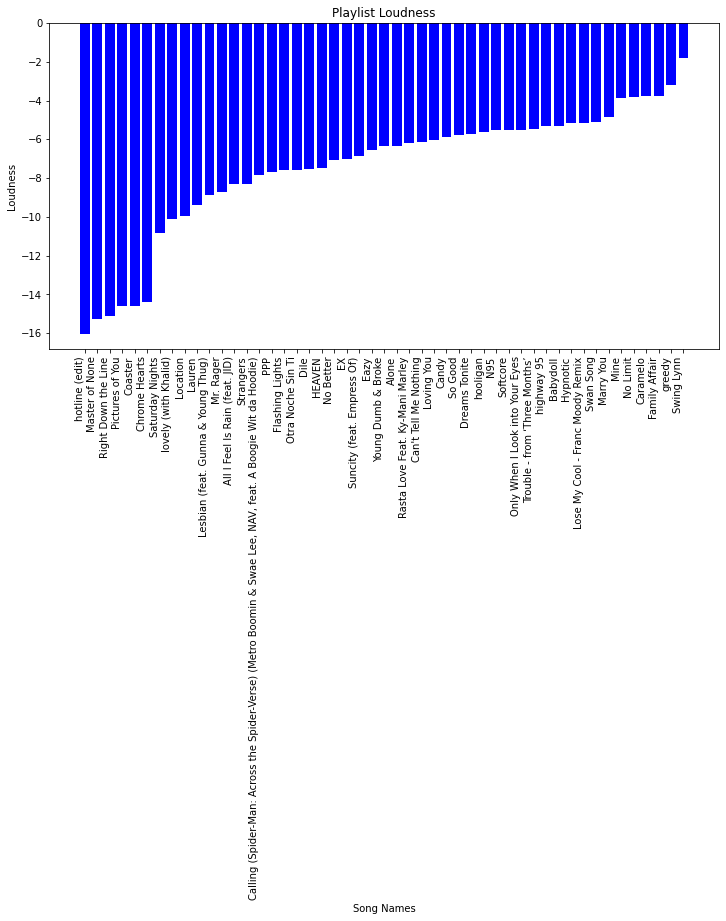

In [16]:
# Plot size
plt.figure(figsize=(12, 6))
# Type of graph (in this case, bar), specifying loudness as subject being graphed, and the color
plt.bar(loudness_sorted_df['name'], loudness_sorted_df['loudness'], color='blue')
# Label the x axis to be track names
plt.xlabel('Song Names')
# And the y to be the loudness
plt.ylabel('Loudness')
# Give the plot a title
plt.title('Playlist Loudness')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, ha='right') 
# Show the plot
plt.show()

Depending on the songs in your playlist, some song names may be too long and affect the readability of the plot. If that is the case, let's address this with some clever **list comprehension** over the x-axis labels and then re-attempt the bar plot.

In [17]:
# Before performing list comprehension, we first need to convert this pandas Series to a list
song_names = loudness_sorted_df['name'].tolist()
# List comprehension: if the song name is longer than 20 characters, truncate it and add '...' to the end
truncated_song_names = [name[:20] + '...' if len(name) > 20 else name for name in song_names]

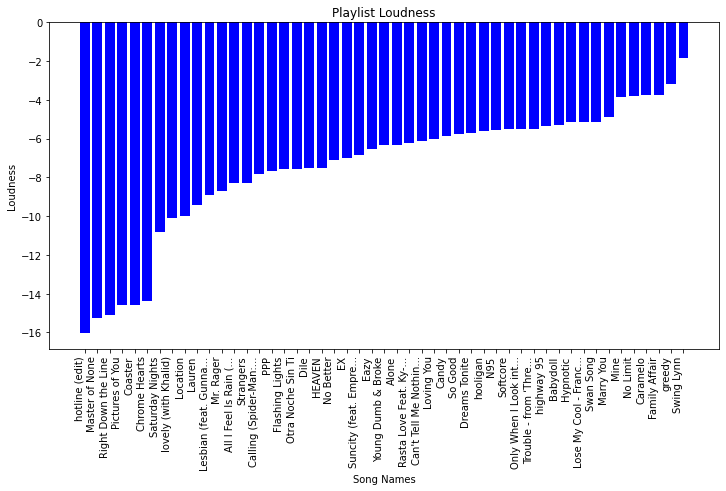

In [18]:
plt.figure(figsize=(12, 6))
# Note that we replaced `loudness_sorted_df['name']` with `truncated_song_names`
plt.bar(truncated_song_names, loudness_sorted_df['loudness'], color='blue')
plt.xlabel('Song Names')
plt.ylabel('Loudness')
plt.title('Playlist Loudness')
plt.xticks(rotation=90, ha='right')
plt.show()

Good job!

Let's try another plot. What about a **pie chart** showing the distribution of different artists in your playlist? Before plotting, we should examine what kind of data is stored in the `artists` column of our DataFrame. Run the code below to see an example.

In [19]:
playlist_df['artists'][0] # Artist(s) of the first song in DataFrame

['Baby Keem']

You may have noticed that for each song, the name(s) of its artist(s) are stored in a list of strings. That is, the `artists` column of the DataFrame is a pandas Series of lists of strings. To be able to plot this in a pie chart, we need a list of artist names and a list of their counts — let's do that.

In [20]:
# Flatten into one list of all artist names
all_artists = [artist for artists in playlist_df['artists'] for artist in artists]
# Get counts of each artist using value_counts, a function provided by pandas
artist_counts = pd.Series(all_artists).value_counts()
# Uncomment the print statement if you'd like!
# print(artist_counts)

With that, we are ready to start plotting.

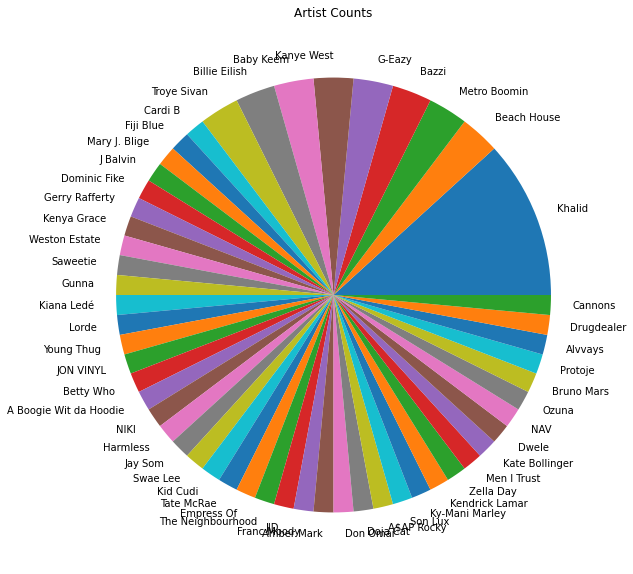

In [21]:
# Plot size
plt.figure(figsize=(10, 10))
# Type of graph (pie), specifying artist_counts as subject being graphed
plt.pie(artist_counts, labels=artist_counts.index)
# Give the plot a title
plt.title('Artist Counts')
# Show the plot
plt.show()

It worked (hopefully)! But if you're anything like us and listen to a wide range of artists, you might notice that your visualization has crowded labels and a slightly chaotic color scheme. Let's improve it!

Instead of displaying all artists, how about we show your top 5 artists and display the rest of the pie as "Other"? Artist names can be lengthy, so another thing we can do to improve readability is to move the labels of each slice to a legend on the side.

In addition, let's change the colors of the pie chart. We could manually select the color of each slice, but the **seaborn** library has a pretty set of pre-defined color palettes! This is the second data visualization library we will be featuring in our tutorial; it is built on top of matplotlib but allows for more advanced and more aesthetic plots. (Spoiler alert: you will be working more with seaborn in the next section of the tutorial as well.)

We already picked a color palette for you, but if you'd like to select something different, you can read more about seaborn color palettes [here](https://seaborn.pydata.org/tutorial/color_palettes.html).

In [22]:
n = 5 # Feel free to adjust this number
top_artists = artist_counts.head(n)
other_artists = artist_counts.iloc[n:].sum()
artist_counts_adjusted = top_artists.append(pd.Series({'Other': other_artists}))

# Uncomment the print statement if you'd like!
# print(artist_counts_adjusted)

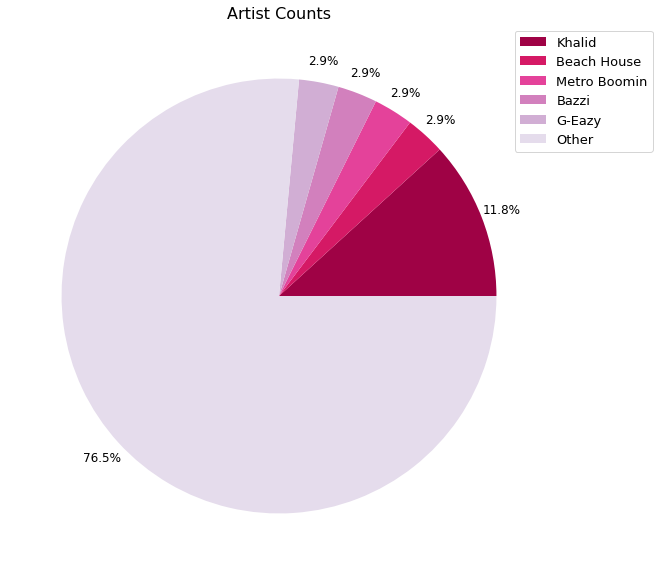

In [23]:
plt.figure(figsize=(10, 10))
plt.pie(
    artist_counts_adjusted, # Switched from artist_counts to artist_counts_adjusted
    autopct = '%.1f%%', # Displays percentage with 1 decimal place
    pctdistance = 1.1, # Relative distance of percentage from center of pie
    colors = sns.color_palette("PuRd_r"), # Apply seaborn color palette
    textprops = {'size': 12} # Font size
    )
plt.title(
    label = 'Artist Counts',
    fontdict={"fontsize":16} # Change font size of title
)
# Move labels to a legend
plt.legend(
    artist_counts_adjusted.index, 
    loc = "upper right", # Position of legend, relative to specified coordinates
    bbox_to_anchor = (1.2, 1), # Specify desired coordinates of legend
    prop = {'size': 13} # Font size
)
# Show the plot
plt.show()

Now that we've had some experience with basic data analysis and visualization, let's advance to the last part of this tutorial: data as art!

## Data as Art
**NOTE TO HANNAH THIS IS WHERE YOU START! <3**

**NOTE: EVERYTHING BELOW IS SCRAP CODE / NOT CLEANED UP. PLEASE IGNORE BUT DON'T REMOVE YET.**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Section-1:-Getting-Started" data-toc-modified-id="Section-1:-Getting-Started-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Section 1: Getting Started</a></span><ul class="toc-item"><li><span><a href="#Setting-up-your-repository" data-toc-modified-id="Setting-up-your-repository-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setting up your repository</a></span></li><li><span><a href="#Setting-up-Jupyter-Notebook" data-toc-modified-id="Setting-up-Jupyter-Notebook-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Setting up Jupyter Notebook</a></span></li><li><span><a href="#Opening-the-notebook" data-toc-modified-id="Opening-the-notebook-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Opening the notebook</a></span></li></ul></li></ul></div>

PROJECT NAME

**Team**: Name 1, Name 2, Name 3

**Summary**: Here's some text describing your project's key goal and motivation of your project. This can be a few sentences.

**Audience**: Individuals with basic Python knowledge looking to try small-scale text classification on their own.

**Libraries used**: List libraries here.

**Vocabulary**: List key concepts that will be defined/explained in your tutorial.

# Section 1: Getting Started

Your tutorial should alternate between text explaining higher-level detail and narrated code excerpts that users can interact with and run. Most likely, you're going to want your first section to narrate a bit about your goals, and, if needed, import some data. Here, I'm going to illustrate how this might look by using some description of how to get your Jupyter Notebook environment up and running.

## Setting up your repository

*If you've taken CS 70, you're probably familiar with some of these instructions; feel free to skim ahead or do what works for you.*

To get started, your team will want its own repository. You'll need Git installed on your computer to work with this, as well as a GitHub account. If you haven't set up Git on your computer before, you can [follow these instructions](https://docs.github.com/en/get-started/quickstart/set-up-git) to get things installed. These instructions include setting up a way to verify credentials (that is, to help your computer access your GitHub repositories by linking to your account). You're welcome to do this using either the HTTPS or SSH recommendations; I've found the SSH option easier to maintain.

First, make sure you get all of your team members' GitHub usernames; then, create a repository for your team using the GitHub Classroom link [here](https://classroom.github.com/a/sYhLcnVM). This will clone a repository with a few starting files:

* a `README` Markdown file where you can keep notes about how to get your project running,
* this Jupyter Notebook (as `project.ipynb`),
* a sample data file `test.txt` (which you can delete when you no longer wish to use it), and
* a hidden file called `.gitignore`. This provides a list of regular expressions of files that git will ignore by default instead of trying to commit. If your tutorial generates a large file that you don't want committed, it may be useful to add the path to that file to this list.

Once this is installed, you should use the instructions to actually [clone your repository](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) on your local computer. This will give you a locally editable copy of the code that you can change and synchronize with the online copy your team will use. Find a folder where it can live for a while, as this repository will be used for the remainder of the semester.

**If you prefer to edit using Visual Studio Code**, it should be able to support Jupyter Notebook editing and operations for git. Make sure that you have the extensions for Git set up so you can commit as you make changes. Eventually, we will be using the command line operations for Git in this class, but if you have another workflow that's working for now, feel free to stick to that.

## Setting up Jupyter Notebook

If you've already installed Anaconda or Python + Jupyter Notebook some other way on your computer, you're good to go! But if you haven't, then now is the time.

The easiest way to get everything running at once if you're starting from scratch is to install [Anaconda](https://www.anaconda.com/products/distribution), which is a Python distribution that comes pre-packaged with a lot of standard scientific/data oriented open-source libraries as well as tools like Jupyter Notebooks and the `conda` package management system. You can use the [website download link](https://www.anaconda.com/products/distribution), making sure you add Anaconda to your PATH variable. If there are extra challenges, it may be worth consulting the [detailed installation instructions](https://docs.anaconda.com/anaconda/install/).

If you'd rather not install all of these packages at once but you still need to install Python, you can also use [miniconda](https://docs.conda.io/en/latest/miniconda.html), a lighter-weight option, or just [install Python directly](https://www.python.org/downloads/). In either case, you'll also need to [install Jupyter Notebook](https://docs.jupyter.org/en/latest/install/notebook-classic.html#alternative-for-experienced-python-users-installing-jupyter-with-pip) afterwards.

## Opening the notebook

Once you have your repository cloned to your computer and Jupyter Notebook installed, all you should need to do to open the notebook is to run

`jupyter notebook`

in the command line. This should kick off a process that prints a link to a Jupyter Notebook server running locally on your computer (e.g. `http://localhost:8888/?token=blahblahblahblah`). If you open that link in your browser, you should see something like this:

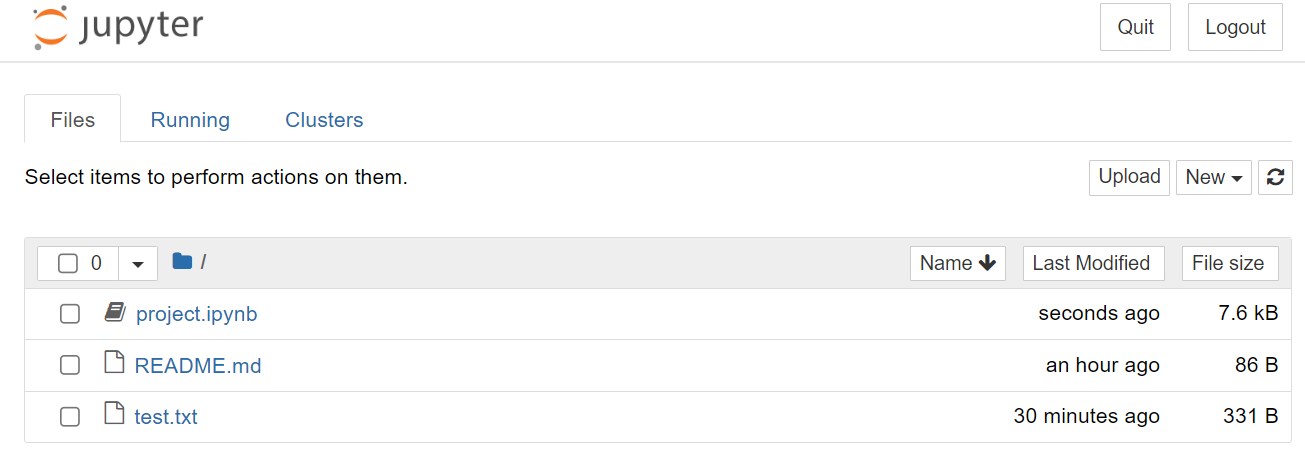

You can click on the project.ipynb notebook icon to open a new window with this notebook, which will give you editable control of the notebook.
* To run a code cell, you can type `Shift+Enter`.
* To change cells from being code to being Markdown (formatted text), use the drop-down menu below the Navigate menu.
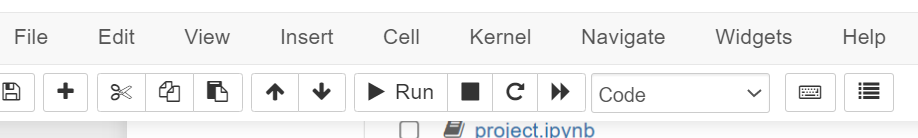
* Make sure to save (`Ctrl+S`) regularly as you work.

Here's some code you can try running to get started:

In [ ]:
# this line helps us render plots inside our notebook
%matplotlib inline

# imports
import random
from matplotlib import pyplot as plt
import matplotlib.cm as cm

# generate a 25 x 25 heatmap of random numbers
dim = 25
data = [[random.uniform(0, 5) for i in range(dim)] for j in range(dim)]

# using Matplotlib documentation:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(data, cmap=cm.tab20)

If all goes well, you should now see a square plot of brightly-colored squares!